<a href="https://colab.research.google.com/github/marcelounb/BB/blob/master/ia_mobile_TF_many_categories_final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
path = "/content/fulldataset.xlsx"

In [4]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

responsavel       = dataset[dataset.columns[0]].tolist()   # Responsável
natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
detalhamento      = dataset[dataset.columns[4]].tolist()   # Detalhamento
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [5]:
dataset.columns

Index(['Responsável', 'Natureza', 'Classificação', 'Produtos/Serviços',
       'Detalhamento', 'Descrição do Problema', 'Produtos/Serviços 2',
       'Detalhamento 2', 'Descrição do Problema 2', 'Produtos/Serviços 3',
       'Detalhamento 3', 'Descrição do Problema 3', 'id', 'userName',
       'userImage', 'review', 'score', 'thumbsUpCount', 'appVersion', 'date',
       'reply', 'replyDate'],
      dtype='object')

# Reduzindo o texto (retirando artigos, pontuacao e conjuncao 'e')

In [6]:
def reduzir_texto(frases):
  frase = ''
  for item in frases.lower().split():
    if item not in ['a', 'o', 'as', 'os', 'da', 'do', 'das', 'dos', 'e']:  # retira os artigos e conjuncao 'e'
      if item[-1] in ['.', ',', '!', ';' ]:
        frase +=str(item[0:-1])+' '  # retira pontuacao
      else:
        frase +=str(item)+' '

  return frase[:-1]

In [7]:
review_reduzida = []
for item in review:
  review_reduzida.append(reduzir_texto(item))
print(review[0:5])
print(review_reduzida[0:5])

['O aplicativo possibilita fazer todas as movimentações e acompanhar seu andamento. È fàcil de utilizar, ràpido e possue todas as informações necessàrias ao cliente.', 'Bom', 'Muito bom, gosto muito', 'Muito bom', 'Muito bom tem me ajudado muito pois faço tudo sem precisar sair de casa👏👏👏👏👏']
['aplicativo possibilita fazer todas movimentações acompanhar seu andamento è fàcil de utilizar ràpido possue todas informações necessàrias ao cliente', 'bom', 'muito bom gosto muito', 'muito bom', 'muito bom tem me ajudado muito pois faço tudo sem precisar sair de casa👏👏👏👏👏']


# Separando as bases de treinamento e de testes

In [8]:
# Separate out the sentences and labels into training and test sets
training_size = int(len(review) * 0.8)

training_sentences = review[0:training_size]
testing_sentences = review[training_size:]
training_labels = classificacao[0:training_size]
testing_labels = classificacao[training_size:]

In [9]:
type(training_labels[2])

str

In [10]:
# Tokenizing classificacao
tokenizer = Tokenizer()
tokenizer.fit_on_texts(classificacao)
word_index = tokenizer.word_index
print(word_index)
prediction_classes = word_index
reversed_prediction_classes = {value : key[0].upper() + key[1:] for (key, value) in prediction_classes.items()}
print(reversed_prediction_classes)

{'elogio': 1, 'reclamação': 2, 'crítica': 3, 'neutra': 4, 'dúvida': 5, 'sugestão': 6, 'solicitação': 7, 'resposta': 8}
{1: 'Elogio', 2: 'Reclamação', 3: 'Crítica', 4: 'Neutra', 5: 'Dúvida', 6: 'Sugestão', 7: 'Solicitação', 8: 'Resposta'}


In [11]:
len(word_index)
tamanho_classes = len(word_index)+1

In [12]:
def transforming_labels(lista):
  temp = []
  for item in lista:
    temp.append(word_index.get(item.lower()))
  return temp

In [13]:
training_labels = transforming_labels(training_labels)
testing_labels = transforming_labels(testing_labels)

In [14]:
training_labels[0:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]

In [15]:
# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [16]:
training_labels_final

array([1, 1, 1, ..., 1, 1, 1])

In [17]:
print(training_sentences[0:5])

['O aplicativo possibilita fazer todas as movimentações e acompanhar seu andamento. È fàcil de utilizar, ràpido e possue todas as informações necessàrias ao cliente.', 'Bom', 'Muito bom, gosto muito', 'Muito bom', 'Muito bom tem me ajudado muito pois faço tudo sem precisar sair de casa👏👏👏👏👏']


In [18]:
print(training_labels[0:20], testing_labels[0:20])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Tokenize the dataset
Tokenize the dataset, including padding and OOV

In [19]:
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

# Review a Sequence
Let's quickly take a look at one of the padded sequences to ensure everything above worked appropriately.

In [20]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, 'x') for i in text])

print(decode_review(padded[0]))
print(training_sentences[0])

o aplicativo <OOV> fazer todas as movimentações e acompanhar seu <OOV> è <OOV> de utilizar <OOV> e <OOV> todas as informações <OOV> ao cliente x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x
O aplicativo possibilita fazer todas as movimentações e acompanhar seu andamento. È fàcil de utilizar, ràpido e possue todas as informações necessàrias ao cliente.


In [21]:
training_labels_final[1]

1

# Train a Basic Sentiment Model with Embeddings

In [22]:
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(50, activation='relu', input_shape=(100,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(tamanho_classes, activation='softmax')
])


# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           16000     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               160100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 4

In [23]:
num_epochs = 4
hist = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/4
130/130 [==============================] - 1s 6ms/step - loss: 0.5461 - accuracy: 0.8945 - val_loss: 0.3479 - val_accuracy: 0.9066
Epoch 2/4
130/130 [==============================] - 1s 4ms/step - loss: 0.2245 - accuracy: 0.9448 - val_loss: 0.2560 - val_accuracy: 0.9306
Epoch 3/4
130/130 [==============================] - 1s 4ms/step - loss: 0.1610 - accuracy: 0.9588 - val_loss: 0.2434 - val_accuracy: 0.9364
Epoch 4/4
130/130 [==============================] - 1s 4ms/step - loss: 0.1223 - accuracy: 0.9658 - val_loss: 0.2677 - val_accuracy: 0.9393


In [24]:
scores = model.evaluate(testing_padded, testing_labels_final, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 6.07%


In [25]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

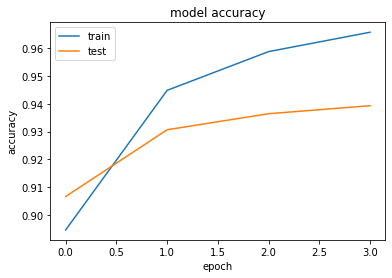

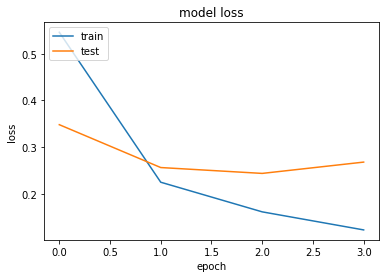

In [26]:
plt.plot(hist.history[ 'accuracy' ])
plt.plot(hist.history[ 'val_accuracy' ])
plt.title( 'model accuracy' )
plt.ylabel( 'accuracy')
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()
# summarize history for loss
plt.plot(hist.history[ 'loss' ])
plt.plot(hist.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()

# Novas Predições:

In [27]:
path = "/content/predicao-arquivo-novo.xlsx"

In [28]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

responsavel       = dataset[dataset.columns[0]].tolist()   # Responsável
natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
detalhamento      = dataset[dataset.columns[4]].tolist()   # Detalhamento
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [29]:
# Use the model to predict a review   
new_reviews = review

print(new_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(new_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

print(new_reviews[17])
print(classes[0:17])

['Sensacional adorei', 'Faço absolutamente tudo pelo App.\nRápido e eficiente. 👏', 'Consigo fazer praticamente tudo sem ter que precisar do atendimento dentro do Banco.', 'Excelente', 'Aplicativo pratico e sem defeitos!', 'Excelente produto, obrigado.', 'Obg Banco do Brasil por ser esse banco incrível...', 'Excelente app!', 'O app é muito prático. Ajuda muito para eu não perder tempo com serviços bancários. Muito bom!', 'Muito bom ter um App tão seguro e tão ágil, simples para qualquer idade!', 'Melhor app de banco que existe', 'Excelente gerenciador financeiro. Parabéns aos desenvolvedores.', 'Bom aplicativo. Cumpre o que é esperado pelo cliente.', 'Eu solicitei o cartão de crédito, enviei todos os documentos, fui aprovado mas na hora de escolher o melhor cartão pra mim não vai, só aparece QUERO ESSE mas não vai nem aparece a foto do cartão.', 'Mto bom pq eh prático, simples e atende as necessidades básicas do dia a dia', 'Apos desinstalar o app e instalar novamente ele não pede mais 

In [30]:
classes_list = classes.tolist()
for contagem in range(15):
  print(contagem, classes_list[contagem].index(np.max(classes[contagem], axis=0, keepdims=True)))

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 2
14 1


In [31]:
max(classes_list[13])

0.9926379919052124

In [32]:
classes_list[13].index(max(classes_list[13]))

2

In [33]:
reversed_prediction_classes

{1: 'Elogio',
 2: 'Reclamação',
 3: 'Crítica',
 4: 'Neutra',
 5: 'Dúvida',
 6: 'Sugestão',
 7: 'Solicitação',
 8: 'Resposta'}

In [34]:
reversed_prediction_classes[2]

'Reclamação'

In [35]:
lista_predicao = []
for item in classes_list:
  lista_predicao.append(reversed_prediction_classes[item.index(max(item))])
lista_predicao[10:20]

['Elogio',
 'Elogio',
 'Elogio',
 'Reclamação',
 'Elogio',
 'Reclamação',
 'Reclamação',
 'Elogio',
 'Elogio',
 'Elogio']

In [36]:
dataset[dataset.columns[2]] = lista_predicao
dataset.head(3)

,Responsável,Natureza,Classificação,Produtos/Serviço 1,Detalhamento 1,Problema 1,Produtos/Serviço 12,Detalhamento 12,Problema 2,Produtos/Serviço 13,Detalhamento 3,Problema 3,id,userName,title,review,rating,thumbsUpCount,version,date,reply,replyDate
0,Automático,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6302065085,Dudu chamba,Perfeito,Sensacional adorei,5,NaN,7.26.4,2020-08-10 08:14:41,NaN,NaT
1,Automático,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6302063114,IzaMMR,Excelente e confiável,Faço absolutamente tudo pelo App.\nRápido e ef...,5,NaN,7.26.4,2020-08-10 08:13:56,NaN,NaT
2,Automático,Negocial,Elogio,Aplicativo,Usabilidade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6302056613,Dayanne wendy(ronald),Muito bom,Consigo fazer praticamente tudo sem ter que pr...,5,NaN,7.26.4,2020-08-10 08:11:34,NaN,NaT


In [37]:
writer = pd.ExcelWriter("novo_dataset_predito.xlsx")
dataset.to_excel(writer, index=False)
writer.save()